<a href="https://colab.research.google.com/github/Rochit02/ML-lab/blob/main/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [8]:
import pandas as pd
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Helper Function for Data Loading

In [9]:
def load_data(file_path, has_header=True):
    """
    Load a CSV into DataFrame from a known path.
    """
    try:
        if has_header:
            df = pd.read_csv(file_path)
        else:
            df = pd.read_csv(file_path, header=None)
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

# 3. Purchase Data Functions (A1 & A2)

In [10]:
def analyze_purchase_data_matrices(df):
    numeric_cols = df.columns[1:]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)

    A = df.iloc[:, 1:-1].values
    C = df.iloc[:, -1].values

    dimensionality = A.shape[1]
    num_vectors = A.shape[0]
    rank_A = np.linalg.matrix_rank(A)
    pseudo_inverse_A = np.linalg.pinv(A)
    product_costs = np.dot(pseudo_inverse_A, C)

    results = {
        "dimensionality": dimensionality,
        "num_vectors": num_vectors,
        "rank": rank_A,
        "product_costs": product_costs,
        "product_names": df.columns[1:-1]
    }
    return results

def classify_customers(df):
    df['Category'] = np.where(df.iloc[:, -1] > 200, 'RICH', 'POOR')
    X = df.iloc[:, 1:-2]
    y = df['Category']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# 4. IRCTC Stock Price Data Functions (A3)

In [11]:
def analyze_stock_prices(df):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Price'] = pd.to_numeric(df['Price'].astype(str).str.replace(',', ''), errors='coerce')
    df['Chg%'] = pd.to_numeric(df['Chg%'].astype(str).str.replace('%', ''), errors='coerce') / 100.0
    df.dropna(subset=['Price', 'Chg%', 'Date'], inplace=True)

    mean_price = statistics.mean(df['Price'])
    variance_price = statistics.variance(df['Price'])
    df['Weekday'] = df['Date'].dt.day_name()
    wednesday_prices = df[df['Weekday'] == 'Wednesday']['Price']
    sample_mean_wednesday = statistics.mean(wednesday_prices) if not wednesday_prices.empty else 0
    april_prices = df[df['Date'].dt.month == 4]['Price']
    sample_mean_april = statistics.mean(april_prices) if not april_prices.empty else 0

    total_days = len(df)
    loss_days = len(df[df['Chg%'] < 0])
    wednesday_df = df[df['Weekday'] == 'Wednesday']
    profit_on_wednesday_days = len(wednesday_df[wednesday_df['Chg%'] > 0])

    prob_loss = loss_days / total_days if total_days > 0 else 0
    prob_profit_wednesday = profit_on_wednesday_days / total_days if total_days > 0 else 0
    cond_prob_profit_given_wednesday = profit_on_wednesday_days / len(wednesday_df) if not wednesday_df.empty else 0

    results = {
        "mean_price": mean_price,
        "variance_price": variance_price,
        "sample_mean_wednesday": sample_mean_wednesday,
        "sample_mean_april": sample_mean_april,
        "prob_loss": prob_loss,
        "prob_profit_on_wednesday": prob_profit_wednesday,
        "cond_prob_profit_given_wednesday": cond_prob_profit_given_wednesday,
        "data_for_plot": df
    }
    return results

# 5. Thyroid Data Functions (A4–A9)

In [12]:
def preprocess_thyroid_data(df):
    column_names = [
        'age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication',
        'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid',
        'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych',
        'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured',
        'T4U', 'FTI measured', 'FTI', 'TBG measured', 'TBG', 'referral source', 'Class'
    ]
    df.columns = ['Record ID'] + column_names
    df.drop('Record ID', axis=1, inplace=True)
    df.replace('?', np.nan, inplace=True)

    binary_cols = [
        'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant',
        'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid',
        'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych'
    ]
    numeric_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']

    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    for col in binary_cols:
        df[col] = df[col].map({'f': 0, 't': 1})

    df.drop('TBG', axis=1, inplace=True)
    numeric_cols.remove('TBG')

    for col in df.columns:
        if col in numeric_cols:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
        else:
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)
    scaler = MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df, binary_cols, numeric_cols

def calculate_similarity_coefficients(df, binary_cols, numeric_cols):
    vec1_binary = df[binary_cols].iloc[0]
    vec2_binary = df[binary_cols].iloc[1]

    f11 = np.sum((vec1_binary == 1) & (vec2_binary == 1))
    f00 = np.sum((vec1_binary == 0) & (vec2_binary == 0))
    f10 = np.sum((vec1_binary == 1) & (vec2_binary == 0))
    f01 = np.sum((vec1_binary == 0) & (vec2_binary == 1))

    jc = f11 / (f11 + f10 + f01) if (f11 + f10 + f01) != 0 else 0
    smc = (f11 + f00) / (len(binary_cols)) if len(binary_cols) > 0 else 0

    vec1_full = df[numeric_cols].iloc[0]
    vec2_full = df[numeric_cols].iloc[1]
    cosine_sim = np.dot(vec1_full, vec2_full) / (np.linalg.norm(vec1_full) * np.linalg.norm(vec2_full))
    results = {
        "jaccard": jc,
        "smc": smc,
        "cosine": cosine_sim
    }
    return results

def generate_similarity_heatmaps(df, binary_cols, numeric_cols):
    n_vectors = 20
    jc_matrix = np.zeros((n_vectors, n_vectors))
    smc_matrix = np.zeros((n_vectors, n_vectors))
    cos_matrix = np.zeros((n_vectors, n_vectors))

    for i in range(n_vectors):
        for j in range(n_vectors):
            vec_i_bin = df[binary_cols].iloc[i]
            vec_j_bin = df[binary_cols].iloc[j]
            f11 = np.sum((vec_i_bin == 1) & (vec_j_bin == 1))
            f00 = np.sum((vec_i_bin == 0) & (vec_j_bin == 0))
            f10 = np.sum((vec_i_bin == 1) & (vec_j_bin == 0))
            f01 = np.sum((vec_i_bin == 0) & (vec_j_bin == 1))
            jc_matrix[i, j] = f11 / (f11 + f10 + f01) if (f11 + f10 + f01) != 0 else 0
            smc_matrix[i, j] = (f11 + f00) / len(binary_cols) if len(binary_cols) > 0 else 0

            vec_i_num = df[numeric_cols].iloc[i]
            vec_j_num = df[numeric_cols].iloc[j]
            cos_matrix[i, j] = np.dot(vec_i_num, vec_j_num) / (np.linalg.norm(vec_i_num) * np.linalg.norm(vec_j_num))

    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    sns.heatmap(jc_matrix, ax=axes[0], annot=False, cmap='viridis').set_title('Jaccard Coefficient')
    sns.heatmap(smc_matrix, ax=axes[1], annot=False, cmap='viridis').set_title('Simple Matching Coefficient')
    sns.heatmap(cos_matrix, ax=axes[2], annot=False, cmap='viridis').set_title('Cosine Similarity')
    fig.suptitle('Similarity Heatmaps for First 20 Vectors (A7)', fontsize=16)
    plt.show()

# 6. Data Analysis/Execution Cells

## 6.1 Purchase Data

In [13]:
purchase_path = "Purchase data.csv"
purchase_df = load_data(purchase_path, has_header=True)

if purchase_df is not None:
    print("--- A1: Purchase Data Matrix Analysis ---")
    purchase_results = analyze_purchase_data_matrices(purchase_df.copy())
    print(f"Dimensionality of the vector space: {purchase_results['dimensionality']}")
    print(f"Number of vectors: {purchase_results['num_vectors']}")
    print(f"Rank of Matrix A: {purchase_results['rank']}")
    print("\nCost of each product:")
    for name, cost in zip(purchase_results['product_names'], purchase_results['product_costs']):
        print(f"- {name}: ₹{cost:.2f}")

    print("\n--- A2: Customer Classification ---")
    accuracy = classify_customers(purchase_df.copy())
    print(f"Classifier model accuracy: {accuracy:.2%}")

--- A1: Purchase Data Matrix Analysis ---
Dimensionality of the vector space: 3
Number of vectors: 10
Rank of Matrix A: 3

Cost of each product:
- Candies (#): ₹1.00
- Mangoes (Kg): ₹55.00
- Milk Packets (#): ₹18.00

--- A2: Customer Classification ---
Classifier model accuracy: 66.67%


## 6.2 IRCTC Stock Price Data

--- A3: IRCTC Stock Price Analysis ---
Mean of Price data: 1560.66
Variance of Price data: 58732.37

Sample mean for Wednesdays: 1550.71
Sample mean for April: 1698.95

Probability of making a loss: 49.80%
Probability of making a profit on Wednesday: 8.43%
Conditional probability of profit, given Wednesday: 42.00%


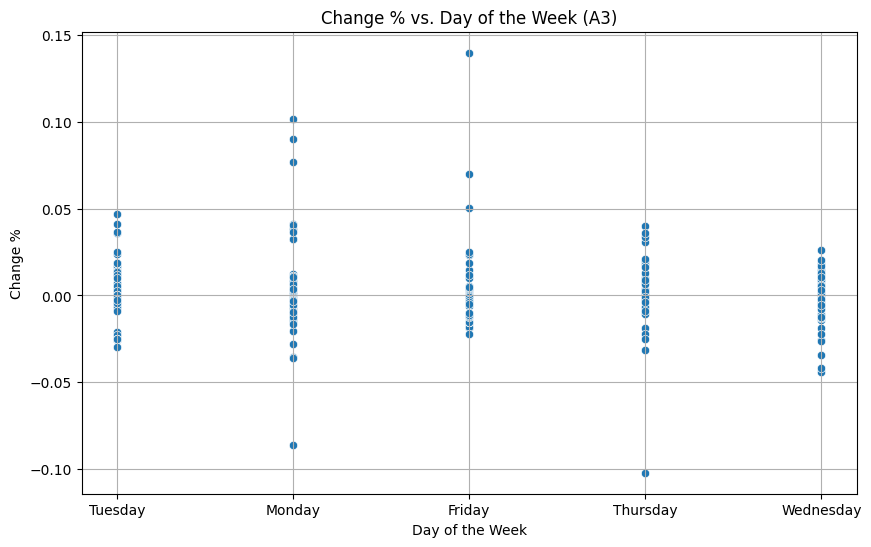

In [14]:
stock_path = "IRCTC Stock Price.csv"
stock_df = load_data(stock_path, has_header=True)

if stock_df is not None:
    print("--- A3: IRCTC Stock Price Analysis ---")
    stock_results = analyze_stock_prices(stock_df.copy())
    print(f"Mean of Price data: {stock_results['mean_price']:.2f}")
    print(f"Variance of Price data: {stock_results['variance_price']:.2f}")
    print(f"\nSample mean for Wednesdays: {stock_results['sample_mean_wednesday']:.2f}")
    print(f"Sample mean for April: {stock_results['sample_mean_april']:.2f}")
    print(f"\nProbability of making a loss: {stock_results['prob_loss']:.2%}")
    print(f"Probability of making a profit on Wednesday: {stock_results['prob_profit_on_wednesday']:.2%}")
    print(f"Conditional probability of profit, given Wednesday: {stock_results['cond_prob_profit_given_wednesday']:.2%}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=stock_results['data_for_plot'], x='Weekday', y='Chg%')
    plt.title('Change % vs. Day of the Week (A3)')
    plt.ylabel("Change %")
    plt.xlabel("Day of the Week")
    plt.grid(True)
    plt.show()

## 6.3 Thyroid Data

--- A4, A8, A9: Thyroid Data Preprocessing ---
Thyroid data has been explored, imputed, and normalized.
First 5 rows of the fully processed data:


,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,referral source,Class
0,0.000824,sex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.103064,TT4 measured,0.170569,T4U measured,0.365741,FTI measured,0.122328,TBG measured,referral source,Condition
1,0.000427,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.103064,f,0.170569,f,0.365741,f,0.122328,f,other,NO CONDITION
2,0.000427,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.103064,t,0.210702,f,0.365741,f,0.122328,f,other,NO CONDITION
3,0.000610,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.103064,f,0.170569,f,0.365741,f,0.122328,t,other,NO CONDITION
4,0.000534,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.103064,f,0.170569,f,0.365741,f,0.122328,t,other,NO CONDITION


--- A5 & A6: Similarity Coefficients ---
Jaccard Coefficient (JC) between first 2 vectors: 0.0000
Simple Matching Coefficient (SMC) between first 2 vectors: 0.9286
Cosine Similarity between first 2 vectors (full numeric): 1.0000
--- A7: Similarity Heatmaps ---


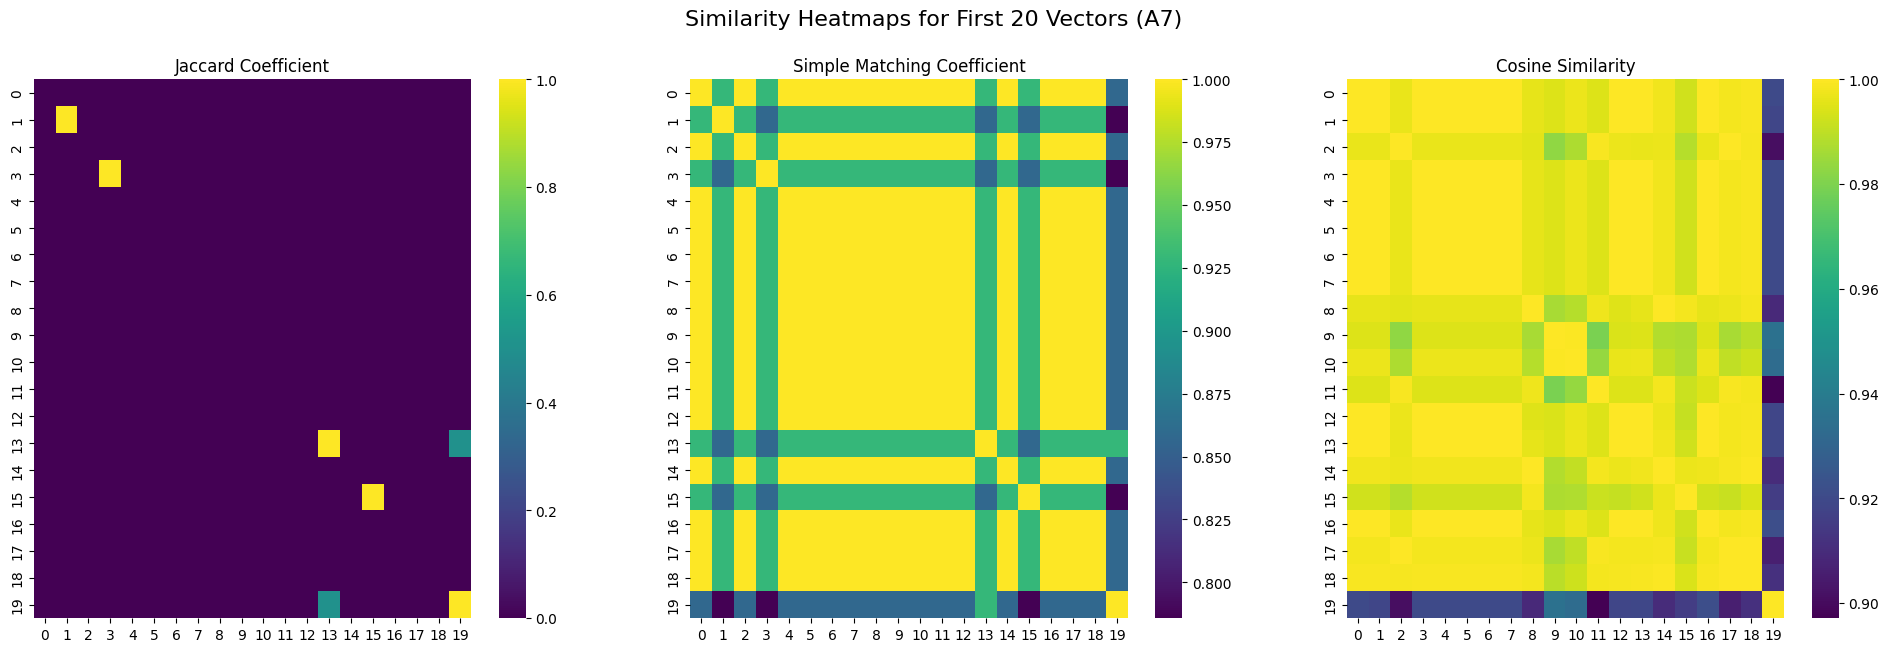

In [15]:
thyroid_path = "thyroid0387_UCI.csv"
thyroid_df = load_data(thyroid_path, has_header=False)

if thyroid_df is not None:
    print("--- A4, A8, A9: Thyroid Data Preprocessing ---")
    processed_thyroid_df, binary_cols, numeric_cols = preprocess_thyroid_data(thyroid_df.copy())
    print("Thyroid data has been explored, imputed, and normalized.")
    print("First 5 rows of the fully processed data:")
    display(processed_thyroid_df.head())

    print("--- A5 & A6: Similarity Coefficients ---")
    similarity_results = calculate_similarity_coefficients(processed_thyroid_df, binary_cols, numeric_cols)
    print(f"Jaccard Coefficient (JC) between first 2 vectors: {similarity_results['jaccard']:.4f}")
    print(f"Simple Matching Coefficient (SMC) between first 2 vectors: {similarity_results['smc']:.4f}")
    print(f"Cosine Similarity between first 2 vectors (full numeric): {similarity_results['cosine']:.4f}")

    print("--- A7: Similarity Heatmaps ---")
    generate_similarity_heatmaps(processed_thyroid_df, binary_cols, numeric_cols)